# IMA204 Practical Session - Segmentation of medical images



# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK FIRST TO GET A FULL OVERVIEW OF USE-CASES AND THE NOTION OF HYPERPARAMETERS.**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Working_directory =  c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA204\TPs\TP4 - Medical Image Segmentation\IMA204---TP3-Medical-Segmentation


In [2]:
def my_kmeans(image, k):
    # k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    # print(centers)
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image, segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors
    
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA204\TPs\TP4 - Medical Image Segmentation\IMA204---TP3-Medical-Segmentation/data/abdominalCT\CTs1.tiff
[  0 127 255]


Text(0.5, 1.0, 'Image +contour tumor')

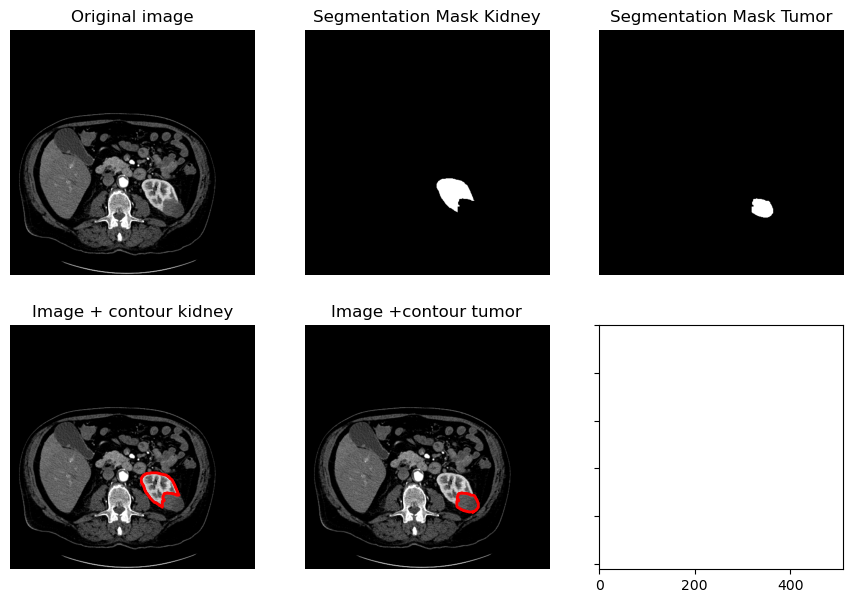

In [3]:
abdominalCT_path = Working_directory + '/data/abdominalCT'  
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=0 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")


# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['c:\\Users\\lmcastanedame\\OneDrive - Universidad Nacional de Colombia\\MANUELA\\TÉLÉCOM\\IMA\\IMA204\\TPs\\TP4 - Medical Image Segmentation\\IMA204---TP3-Medical-Segmentation/data/brainMRI\\MRIs1-seg.png', 'c:\\Users\\lmcastanedame\\OneDrive - Universidad Nacional de Colombia\\MANUELA\\TÉLÉCOM\\IMA\\IMA204\\TPs\\TP4 - Medical Image Segmentation\\IMA204---TP3-Medical-Segmentation/data/brainMRI\\MRIs2-seg.png', 'c:\\Users\\lmcastanedame\\OneDrive - Universidad Nacional de Colombia\\MANUELA\\TÉLÉCOM\\IMA\\IMA204\\TPs\\TP4 - Medical Image Segmentation\\IMA204---TP3-Medical-Segmentation/data/brainMRI\\MRIs3-seg.png', 'c:\\Users\\lmcastanedame\\OneDrive - Universidad Nacional de Colombia\\MANUELA\\TÉLÉCOM\\IMA\\IMA204\\TPs\\TP4 - Medical Image Segmentation\\IMA204---TP3-Medical-Segmentation/data/brainMRI\\MRIs4-seg.png']
Reading image  c:\Users\lmcastanedame\OneDrive - Universidad Nacional de Colombia\MANUELA\TÉLÉCOM\IMA\IMA204\TPs\TP4 - Medical Image Segmentat

Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

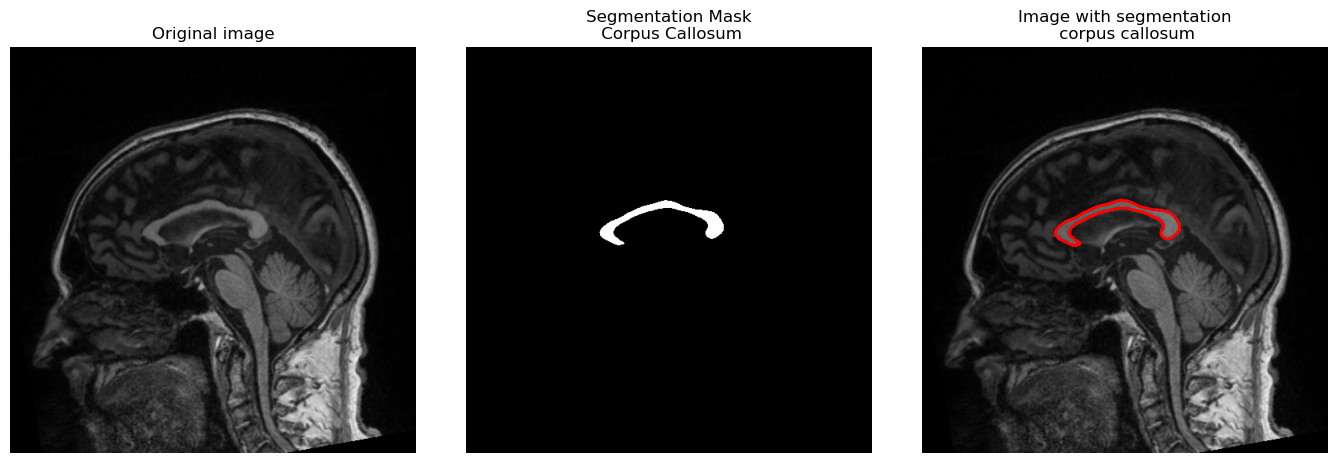

In [4]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Preliminaries

## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



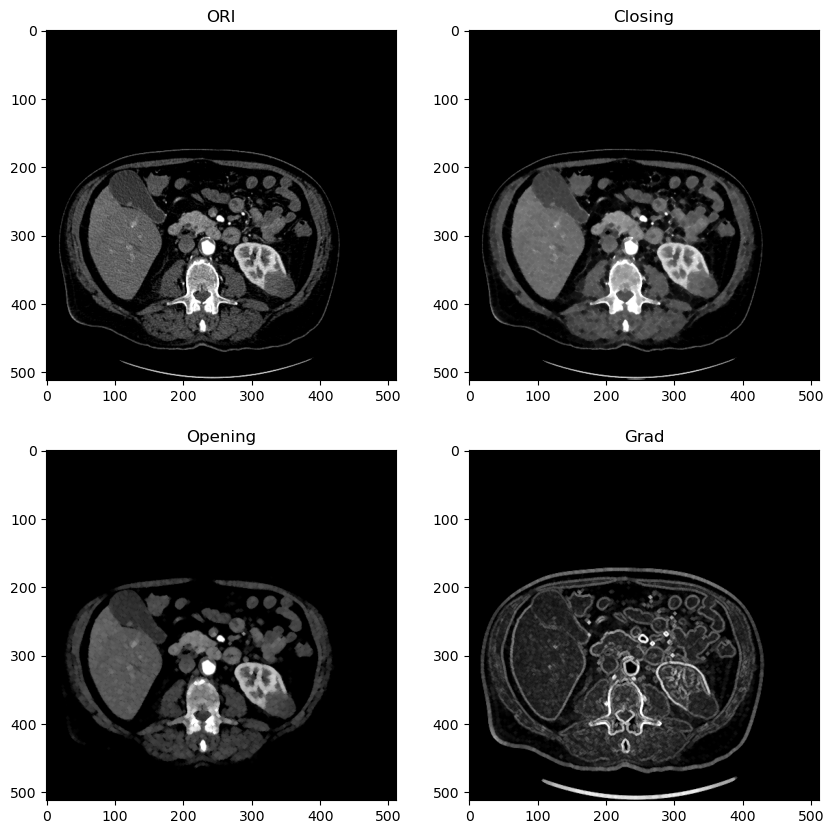

In [5]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

## Regular filtering

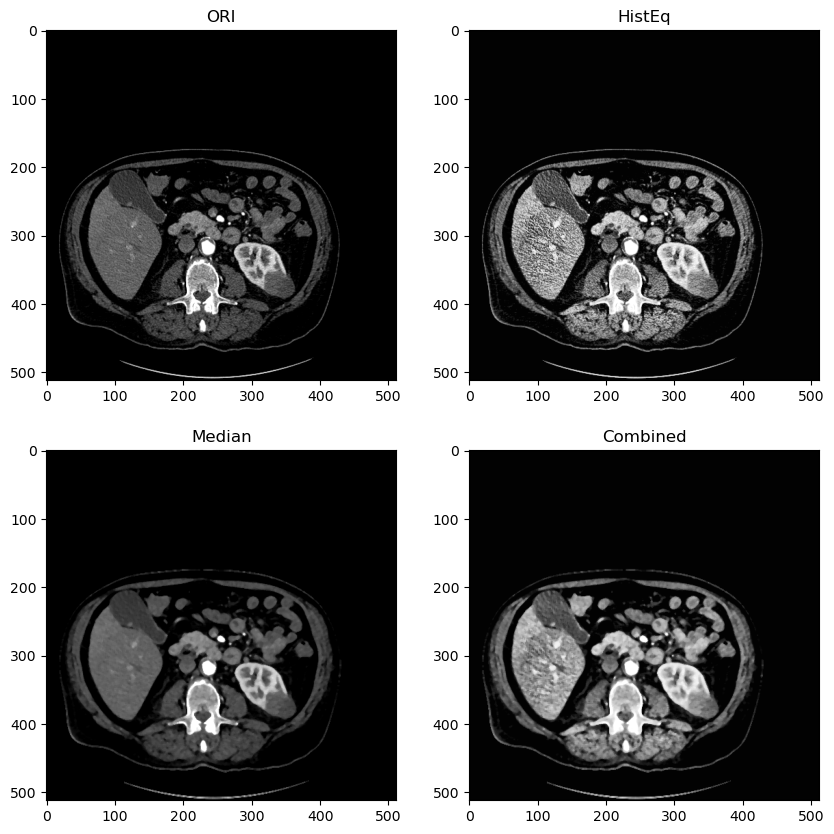

In [6]:
img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");

# ASSIGNMENT:

**Question** 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images 
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images

Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

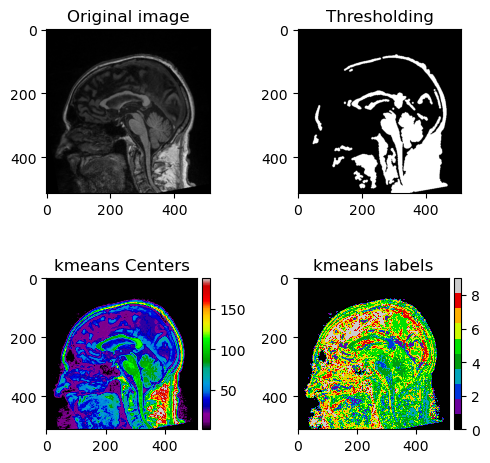

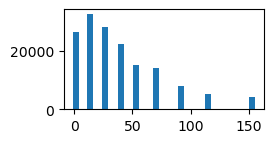

Your Target_value =  97
Distance of your Target_value to Centers =  [95 44 18 92  5 70 27 56 57 83]
Your selected label (starting with 0)=  4


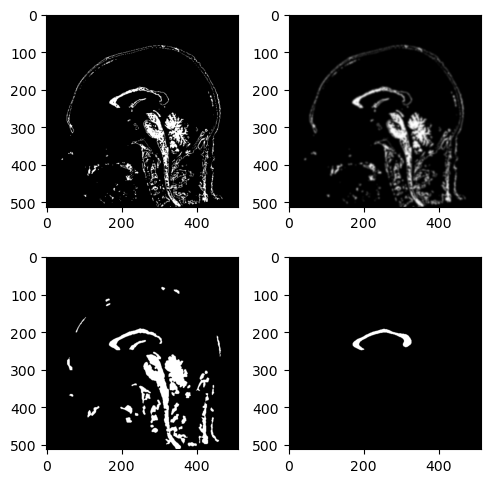

In [7]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image


# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()

## From Kmeans to Connected Components

This is an example on how to exploit the results from Kmeans.
Note that this example uses several hard-coded **hyperparameters** which is not appropriate to segment robustly several cases. 

If you reuse this piece of code for the question below, propose some approaches to set some of the hyperparameter values automatically (eg using the known average size of the structure of interest from the gt segmentation you have)

Max value in labels =  21
Number of connected components =  22


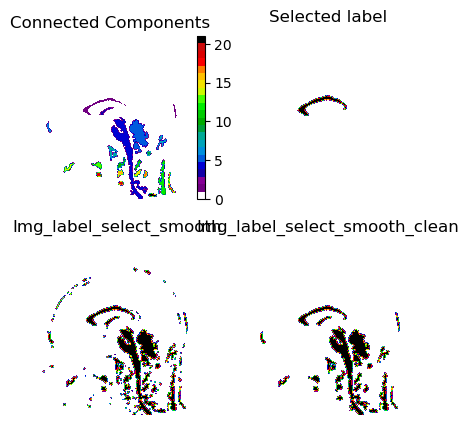

In [8]:
Img_label_select_filter = gaussian(Img_label_select, 2, 
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==1

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');

# Implement your full segmentation pipeline

## TO DO:
* Implement a full pipeline to segment TWO EXAMPLES from a single use case. Your code must run over the two cases in a loop. We need to be able to run the code without any adjustment to local path to access the input data. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Extra point if you provide results on more use-cases or more than 2 examples per use case. <br>
* Feel free to also test your segmentation pipeline on images degraded by noise for example. <br>
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>

### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

#### Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>

For cardiac MRI: how to create a binary mask from the provided contours

MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value: [[-99999]]


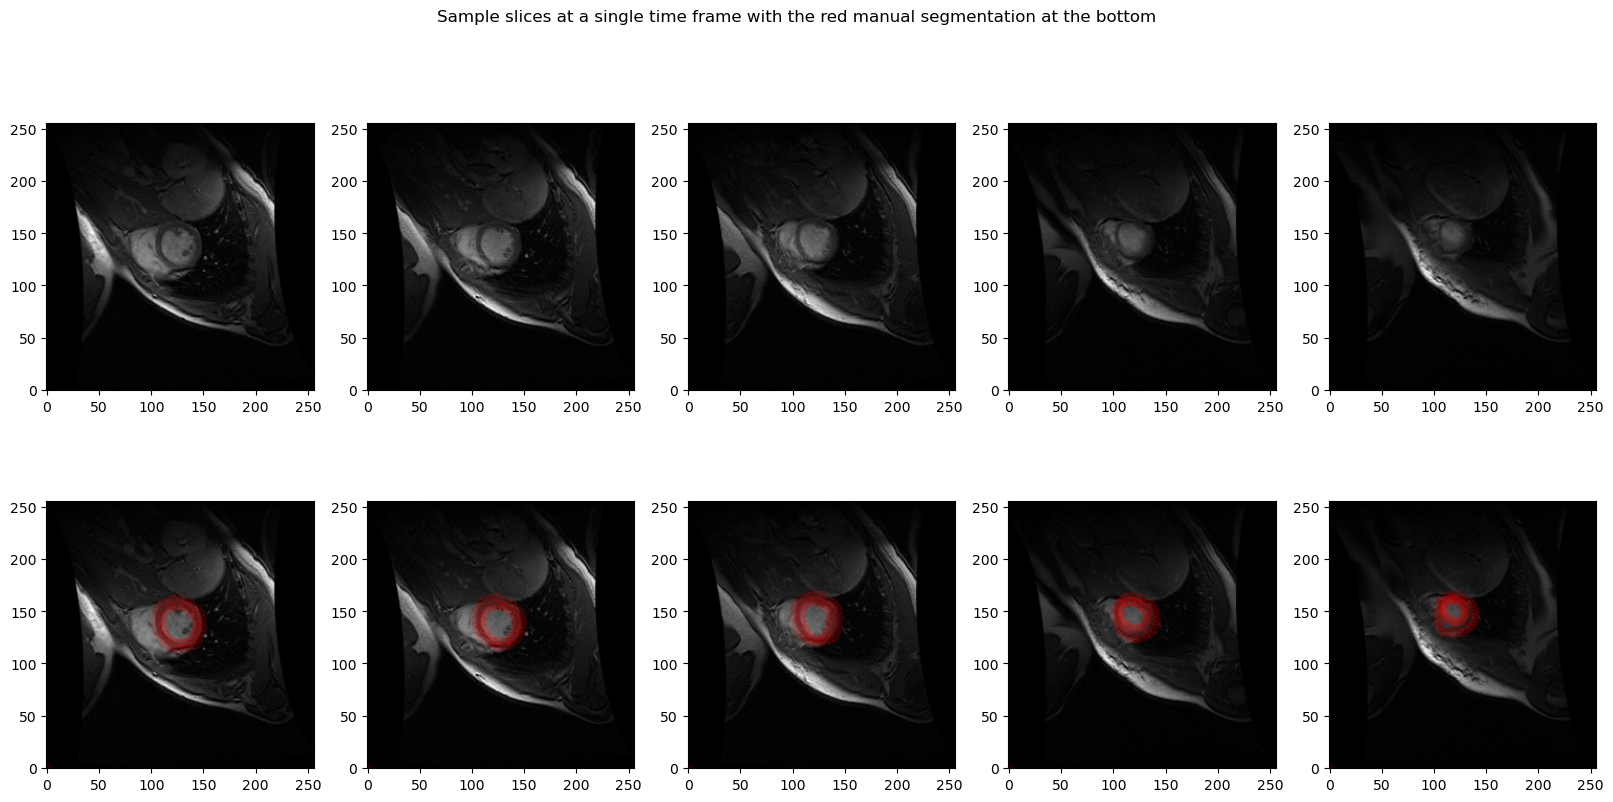

In [9]:
# Read one case
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 6
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Sample slices at a single time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1); 

# Development

The following code cell is performing several operations related with initialization of both images and masks (ground truths):

1. **Importing the necessary module:** The code imports the `polygon` function from the `skimage.draw` module. This function will be used later to create a binary mask representing the ground truth segmentation.

2. **Defining the examples:** The code defines two examples, `Ex_index_select_1` and `Ex_index_select_2`, which represent the indices of the examples to be processed. These indices are used to extract specific slices from the `data` array.

3. **Extracting image and contour data:** The code extracts the image data for the two examples from the `data` array using the specified indices. The image data is stored in the variables `Img_cardiac_ex1` and `Img_cardiac_ex2`. Similarly, the contour data for the two examples is extracted from the `seg` array and stored in the variables `Cont_cardiac_ex1` and `Cont_cardiac_ex2`.

4. **Removing zero points from the contour:** The code removes any contour points that have coordinates [0, 0] from the extracted contour data. This is done using the `np.all` function and the `~` operator to negate the condition. The updated contour data is stored back in the variables `Cont_cardiac_ex1` and `Cont_cardiac_ex2`.

5. **Obtaining the ground truths:** The code creates binary masks representing the ground truth segmentations for the two examples. This is done using the `polygon` function from the `skimage.draw` module. The function takes the contour coordinates and the shape of the corresponding image as inputs and returns the row and column indices of the pixels inside the contour. These indices are then used to set the corresponding elements in the `Seg_cardiac_ex1` and `Seg_cardiac_ex2` arrays to 1, indicating the region of interest.

Overall, this code cell prepares the data for image segmentation by extracting the necessary image and contour data, removing any unwanted contour points, and creating binary masks representing the ground truth segmentations.

In [10]:
from skimage.draw import polygon
# Extracting the data for the two examples -------------------------------------------------------------
# Defining the two examples - data[x, y, z, t] 
# z is the slice index (between 0 and 9) and t is the time frame index (between 0 and 9)

t_frame = 5
Ex_index_select_1, Ex_index_select_2 = 4, 5
Img_cardiac_ex1, Img_cardiac_ex2 = data[:,:,Ex_index_select_1, 1], data[:,:,Ex_index_select_2, 2] 
Cont_cardiac_ex1, Cont_cardiac_ex2  = seg[Ex_index_select_1,1][:], seg[Ex_index_select_2,1][:]

# Remove [0 0] point in provided contour
Cont_cardiac_ex1 = Cont_cardiac_ex1[~np.all(Cont_cardiac_ex1 == 0, axis=1)]
Cont_cardiac_ex2 = Cont_cardiac_ex2[~np.all(Cont_cardiac_ex2 == 0, axis=1)]

# Obtaining the grounds truths
Seg_cardiac_ex1   = np.zeros_like(Img_cardiac_ex1, dtype='bool')
rr1, cc1 = polygon(Cont_cardiac_ex1[:, 1], Cont_cardiac_ex1[:, 0], Img_cardiac_ex1.shape)
Seg_cardiac_ex1[rr1, cc1] = 1

Seg_cardiac_ex2   = np.zeros_like(Img_cardiac_ex2, dtype='bool')
rr2, cc2 = polygon(Cont_cardiac_ex2[:, 1], Cont_cardiac_ex2[:, 0], Img_cardiac_ex2.shape)
Seg_cardiac_ex2[rr2, cc2] = 1

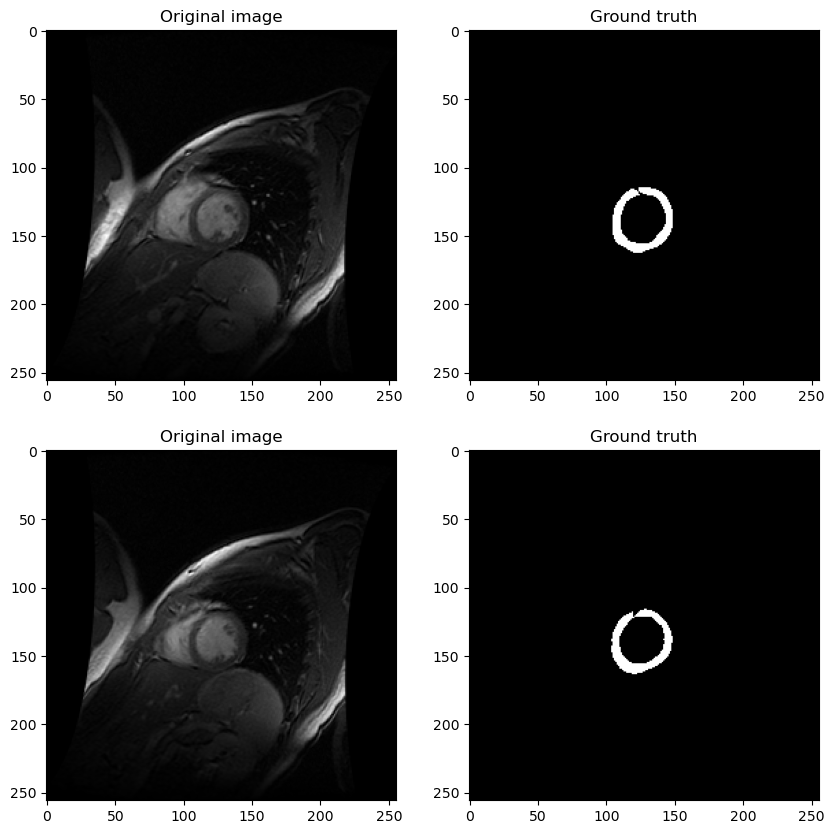

In [11]:
# Plotting the results
fig, axes = plt.subplots(2,2, figsize=(10, 10))
ax        = axes.ravel()

ax[0].imshow(Img_cardiac_ex1, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground truth')
ax[2].imshow(Img_cardiac_ex2, cmap='gray')
ax[2].set_title('Original image')
ax[3].imshow(Seg_cardiac_ex2, cmap='gray')
ax[3].set_title('Ground truth');

* Implement a full pipeline to segment TWO EXAMPLES from a single use case. Your code must run over the two cases in a loop. We need to be able to run the code without any adjustment to local path to access the input data. <br>

The code cell is performing the following tasks:

1. It defines a variable `crop_size` and assigns it a value of 100. This variable represents the size of the region to be cropped from the images.

2. It calculates the center position of the image by dividing the width (256) by 2 and assigns it to the variable `center`.

3. It crops two images (`Img_cardiac_ex1` and `Img_cardiac_ex2`) using the `center` and `crop_size` values. The cropped region is selected from `center - crop_size/2` to `center + crop_size/2` in both the horizontal and vertical directions. The cropped images are assigned to variables `ex_1` and `ex_2`, respectively.

4. It creates an array `examples` containing the two cropped images (`ex_1` and `ex_2`).

5. It plots the original image 1 (`data[:, :, Ex_index_select_1, t_frame]`) in the first subplot and the original image 2 (`data[:, :, Ex_index_select_2, t_frame]`) in the second subplot.

4. It plots the cropped image 1 (`ex_1`) in the third subplot and the cropped image 2 (`ex_2`) in the fourth subplot (`ax[3]`).

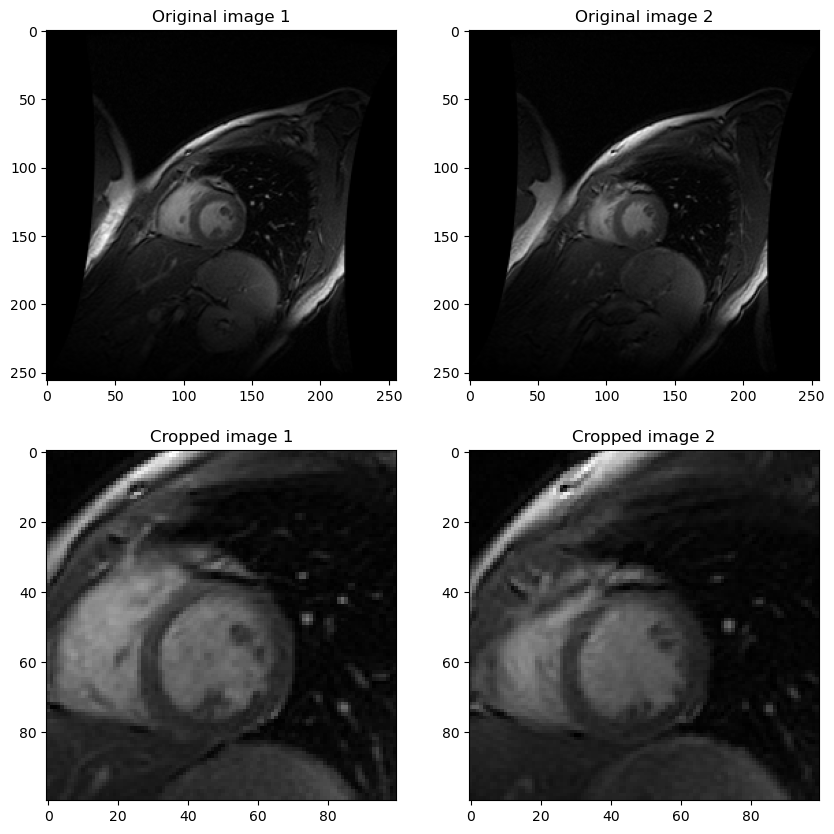

In [12]:
# Cropping the images to remove the black borders
crop_size = 100
center = 256 /2

ex_1 = Img_cardiac_ex1[int(center - crop_size/2) : int(center + crop_size/2), int(center - crop_size/2) : int(center + crop_size/2)]
ex_2 = Img_cardiac_ex2[int(center - crop_size/2) : int(center + crop_size/2), int(center - crop_size/2) : int(center + crop_size/2)]

# Array of the two examples
examples = np.array([ex_1, ex_2])

# Vizualizing the two original images (examples) and the cropped images in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()
ax[0].imshow(data[:, :,Ex_index_select_1, t_frame], cmap='gray')
ax[0].set_title('Original image 1')
ax[1].imshow(data[:, :,Ex_index_select_2, t_frame], cmap='gray')
ax[1].set_title('Original image 2')
ax[2].imshow(ex_1, cmap='gray')
ax[2].set_title('Cropped image 1')
ax[3].imshow(ex_2, cmap='gray')
ax[3].set_title('Cropped image 2')
plt.show()

The provided code cell contains several functions related to image processing:

1. `quantize_image(image, n_bins)`: This function takes an image and the number of bins as input. It quantizes the image by dividing the pixel values into `n_bins` intervals. It creates a new image called `quantized_image` with the same shape as the input image, and assigns each pixel to its corresponding bin based on its intensity value. The function then returns the quantized image.

2. `store_evolution_in(lst)`: This function returns a callback function that can be used to store the evolution of level sets in a given list. The input parameter `lst` is the list where the level sets will be stored. The returned callback function, `_store(x)`, takes a level set `x` as input and appends a copy of it to the provided list `lst`. This function is useful for tracking the evolution of level sets during image segmentation or other similar tasks.

3. `edge_map(img, sigma)`: This function takes an image `img` and a sigma value as input. It applies a Gaussian blur to the image using the `gaussian` function from the `skimage.filters` module with the specified sigma value. Then, it applies the Sobel filter to the blurred image using the `sobel` function from the same module. The result is an edge map that highlights the edges in the image. The function returns the edge map.

Overall, these functions provide functionality for image quantization, storing the evolution of level sets, and generating an edge map from an input image.

In [13]:

# Function to quantize the images
def quantize_image(image, n_bins):
    
    interval = 256 / n_bins
    quantized_image = np.zeros_like(image)

    for i in range(n_bins):
        quantized_image[(image >= i * interval) & (image < (i + 1) * interval)] = i

    return quantized_image

def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def edge_map(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.sobel(blur)

The following code cell is performing a segmentation on two examples of cardiac images:

1. **Initializing arrays:** The code initializes several arrays to store the results of the segmentation process, such as `pre_processed_images`, `segmented_images`, `segmented_labels`, `histograms`, and `bins_hist`. These arrays are used to store intermediate and final results.

2. **Setting preprocessing parameters:** The code sets various parameters for the preprocessing step, such as `clip_limit_`, `f_med_size`, `disk_op`, `disk_cls`, `quant_levels`, `interval`, `disk_op_f`, `disk_cls_f`, `threshold_h`, and `threshold_l`. These parameters control the behavior of the preprocessing operations.

3. **Initializing arrays for segmentation:** The code initializes the `ls` and `binary_mask` arrays. These arrays will store the results of the segmentation process for each example.

4. **Looping over examples:** The code enters a loop that iterates over the two examples of cardiac images. For each example:

   a. *Preprocessing:* The code applies an edge map operation to the example using the `edge_map` function with a sigma value of 2. The result is stored in the `pre_processed_images` array.
   
   b. *Initializing contour:* The code initializes a level set contour using the `disk_level_set` function from the `skimage.segmentation` module. The contour is initialized with a disk shape centered at `[r0, c0]` with a radius of `R0`.
   
   c. *Running geodesic active contour:* The code applies the geodesic active contour algorithm to the preprocessed image using the `morphological_geodesic_active_contour` function from the `skimage.segmentation` module. The result is stored in the `ls` array.
   
   d. *Post-processing:* The code applies several post-processing operations to the segmented image stored in `ls`. These operations include applying a high pass filter, median filtering, thresholding, and closing operation.
   
5. **Plotting the results:** The code plots the results for each example. It creates subplots to display the original image, preprocessed image, contour evolution, and the final segmented image. The contour evolution is visualized using contour lines. 

Overall, the code performs segmentation on two cardiac images using geodesic active contours and displays the results for each example.

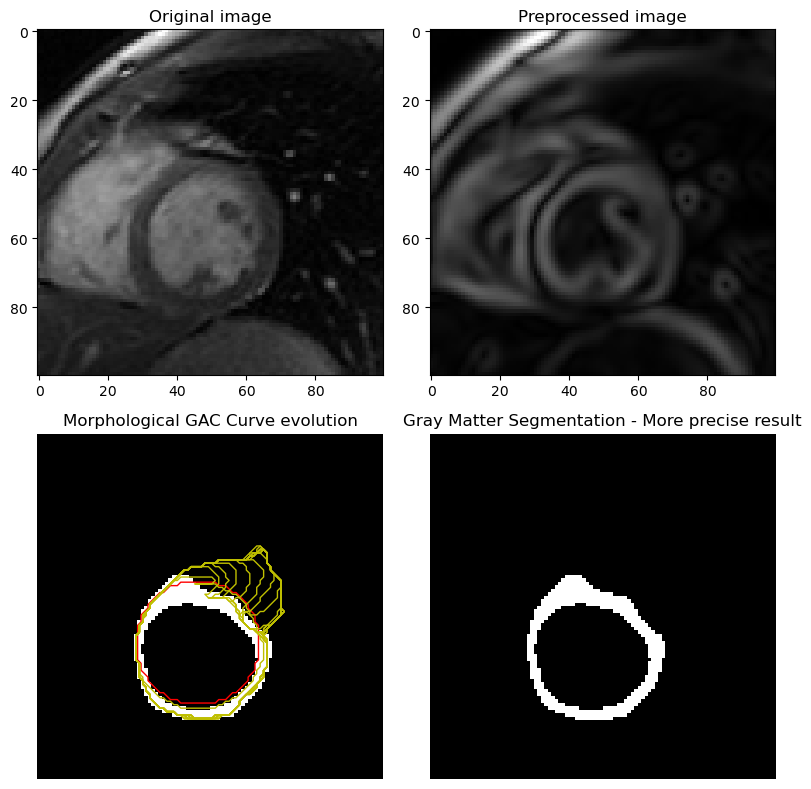

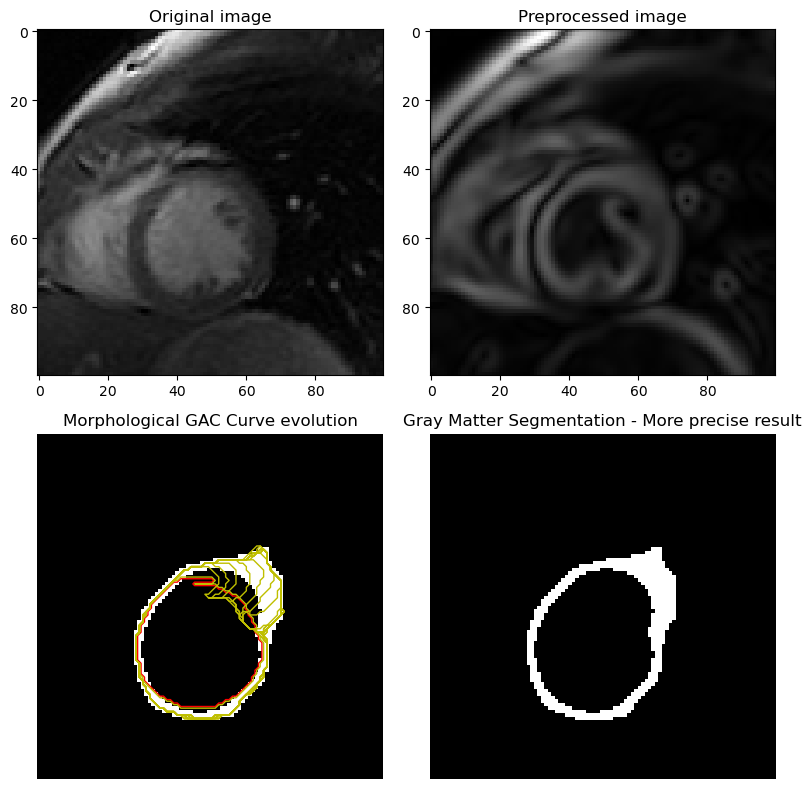

In [14]:
# Inizializing the arrays for the results
pre_processed_images = np.zeros((2, crop_size, crop_size))
segmented_images = np.zeros((2, crop_size, crop_size))
segmented_labels = np.zeros((2, crop_size, crop_size))

histograms = np.zeros((2, 256))
bins_hist = np.zeros((2, 257))

# Parameters of preprocessing
clip_limit_ = 0.01  # Between 0 and 1
f_med_size = 1
disk_op = disk(1)
disk_cls = disk(1)

quant_levels = 10
interval = 256 // quant_levels
disk_op_f = disk(1)
disk_cls_f = disk(1)
threshold_h = 85
threshold_l = 50

# Initialize ls and binary_mask arrays
num_examples, height, width = examples.shape
ls = np.zeros((num_examples, height, width))
binary_mask = np.zeros_like(ls)

# Loop over two examples
for i in range(examples.shape[0]):
    # initialise call back
    evolution = []

    Img_cardiac_ex = examples[i] # Time frame index is 1
    
    pre_processed_images = edge_map(examples, sigma=2)
    
    Niter_snake = 100
    Smooth_cont_iter = 1
    Balloon_weight = 0.1
    Thresh_cont_val = 0.5
    callback = store_evolution_in(evolution)
    R0 = 18
    r0, c0 = 60, 46

    # Initialise contour 
    init_ls = skimage.segmentation.disk_level_set(pre_processed_images[i].shape, center=[r0, c0], radius=R0)

    # Run geodesic active contour
    ls[i] = segmentation.morphological_geodesic_active_contour(pre_processed_images[i], Niter_snake, init_ls,
                                                smoothing=Smooth_cont_iter, balloon=Balloon_weight,
                                                threshold=Thresh_cont_val,
                                                iter_callback=callback)
    
    # Apply a high pass filter to ls[i]
    ls[i] = skimage.filters.sobel(ls[i])

    # Applying a median filter in order to expand the contour
    ls[i] = skimage.filters.median(ls[i], disk(1))

    # Thresholding the image
    ls[i] = ls[i] > 0.1

    # Applying closing operation to ls[i]
    ls[i] = skimage.morphology.closing(ls[i], disk(12))

# Plotting the first example, its histogram and the thresholded image
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(ex_1, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(pre_processed_images[0], cmap='gray')
ax[1].set_title('Preprocessed image')

ax[2].imshow(ls[0], cmap="gray")
ax[2].set_axis_off()

contour_ = ax[2].contour(evolution[0], [0.5], linewidths=1, colors='r')
contour_.collections[0].set_label("Contours")
title = f'Morphological GAC Curve evolution'
ax[2].set_title(title, fontsize=12)

for i in range(1, Niter_snake-1, 5):
    contour_ = ax[2].contour(evolution[i], [0.01], linewidths=1, colors='y')

#ax[3].imshow(ex_1, cmap=plt.cm.gray)
ax[3].imshow(ls[0], cmap=plt.cm.gray)
ax[3].set_title('Gray Matter Segmentation - More precise result')
ax[3].axis('off')

fig.tight_layout()
plt.show()

# Plotting the second example, its histogram and the thresholded image
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(ex_2, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(pre_processed_images[1], cmap='gray')
ax[1].set_title('Preprocessed image')

ax[2].imshow(ls[1], cmap="gray")
ax[2].set_axis_off()

contour_ = ax[2].contour(evolution[1], [0.5], linewidths=1, colors='r')
contour_.collections[0].set_label("Contours")
title = f'Morphological GAC Curve evolution'
ax[2].set_title(title, fontsize=12)

for i in range(1, Niter_snake-1, 5):
    contour_ = ax[2].contour(evolution[i], [0.01], linewidths=1, colors='y')

#ax[3].imshow(ex_2, cmap=plt.cm.gray)
ax[3].imshow(ls[1], cmap=plt.cm.gray)
ax[3].set_title('Gray Matter Segmentation - More precise result')
ax[3].axis('off')


fig.tight_layout()
plt.show()

* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.

The following code cell is:

1. Setting the dimensions of two masks (`mask_ex1` and `mask_ex2`) to match the size of a specific slice of data.
2. Modifying the values of the masks based on a logical condition (`ls[0] != 0` and `ls[1] != 0` respectively).
3. Defining the regions of interest within the masks by assigning non-zero values to a specific area defined by the `center` and `crop_size` variables.
4. Creating a figure with subplots to display the masks and ground truth images.
5. Plotting the first mask (`mask_ex1`) and its corresponding ground truth image (`Seg_cardiac_ex1`) in the first subplot.
6. Plotting the second mask (`mask_ex2`) and its corresponding ground truth image (`Seg_cardiac_ex2`) in the second subplot.
7. Displaying the figure with the plotted images.

This code is visualizing two masks and their corresponding ground truth images in a 2x2 grid of subplots.

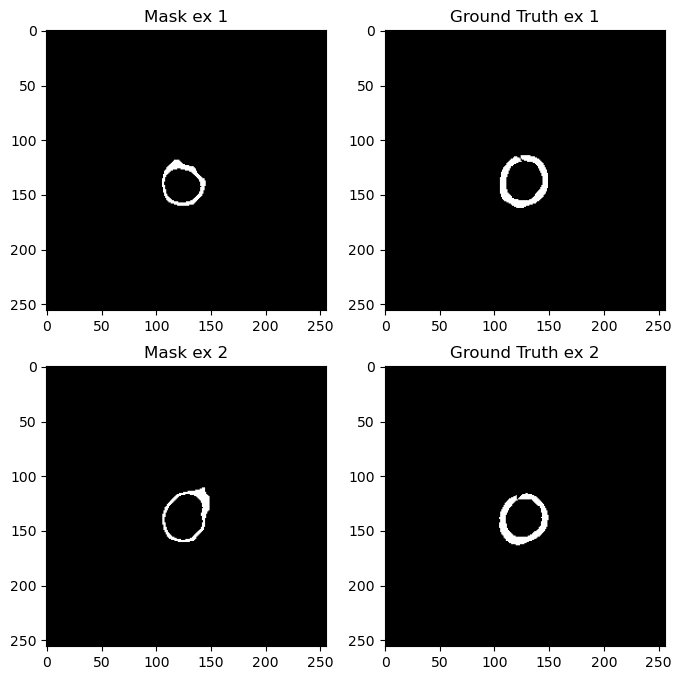

In [15]:
# Setting back the masks dimentions to the original size
# Mask 1 
mask_ex1 = np.zeros_like(data[:, :,Ex_index_select_1, t_frame])
ls[0] = (ls[0] != 0)
mask_ex1[int(center - crop_size/2) : int(center + crop_size/2), 
     int(center - crop_size/2) : int(center + crop_size/2)] = ls[0]

# Mask 2
mask_ex2 = np.zeros_like(data[:, :,Ex_index_select_2, t_frame])
ls[1] = (ls[1] != 0)
mask_ex2[int(center - crop_size/2) : int(center + crop_size/2), 
     int(center - crop_size/2) : int(center + crop_size/2)] = ls[1]

# Plotting the masks and the grounds truths
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(mask_ex1, cmap='gray')
ax[0].set_title('Mask ex 1')
ax[1].imshow(Seg_cardiac_ex1, cmap='gray')
ax[1].set_title('Ground Truth ex 1')

ax[2].imshow(mask_ex2, cmap='gray')
ax[2].set_title('Mask ex 2')
ax[3].imshow(Seg_cardiac_ex2, cmap='gray')
ax[3].set_title('Ground Truth ex 2')
plt.show()

The following cell defines two functions, `calculate_iou` and `calculate_rad`, which are used to calculate the Intersection over Union (IoU) and Relative Area Difference (RAD) metrics, respectively. 

The `calculate_iou` function takes in two binary masks, `predicted_mask` and `ground_truth_mask`, and calculates the IoU between them. It does this by finding the intersection of the two masks using the `np.logical_and` function, and then finding the union of the two masks using the `np.logical_or` function. The IoU is then calculated by dividing the sum of the intersection by the sum of the union. The IoU value is returned by the function.

The `calculate_rad` function also takes in two binary masks, `predicted_mask` and `ground_truth_mask`, and calculates the RAD between them. RAD stands for Relative Area Difference and measures the difference in area between the predicted mask and the ground truth mask relative to the area of the ground truth mask. The RAD is calculated by taking the absolute difference between the sum of the predicted mask and the sum of the ground truth mask, and then dividing it by the sum of the ground truth mask. The RAD value is returned by the function.

After defining the functions, the code calculates the intersection and dice coefficient for two examples, `intersection_1` and `dice_coefficient_1` for example 1, and `intersection_2` and `dice_coefficient_2` for example 2. The dice coefficient is a similarity metric that measures the overlap between two binary masks. It is calculated by taking twice the sum of the intersection and dividing it by the sum of the two masks.

Next, the code calculates the IoU and RAD for the two examples using the `calculate_iou` and `calculate_rad` functions. Finally, the results for both examples are printed, including the dice coefficient, IoU, and RAD values.

In [19]:
def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_rad(predicted_mask, ground_truth_mask):
    rad = np.abs(np.sum(predicted_mask) - np.sum(ground_truth_mask)) / np.sum(ground_truth_mask)
    return rad

intersection_1 = np.logical_and(mask_ex1, Seg_cardiac_ex1)
dice_coefficient_1 = 2. * intersection_1.sum() / (mask_ex1.sum() + Seg_cardiac_ex1.sum())

intersection_2 = np.logical_and(mask_ex2, Seg_cardiac_ex2)
dice_coefficient_2 = 2. * intersection_2.sum() / (mask_ex2.sum() + Seg_cardiac_ex2.sum())

iou_1 = calculate_iou(mask_ex1, Seg_cardiac_ex1)
rad_1 = calculate_rad(mask_ex1, Seg_cardiac_ex1)

iou_2 = calculate_iou(mask_ex2, Seg_cardiac_ex2)
rad_2 = calculate_rad(mask_ex2, Seg_cardiac_ex2)

print("Example 1 -------------------")
print("Dice Coefficient:", dice_coefficient_1)
print("Intersection over Union (IoU):", iou_1)
print("Relative Area Difference (RAD):", rad_1)

print("Example 2 -------------------")
print("Dice Coefficient:", dice_coefficient_2)
print("Intersection over Union (IoU):", iou_2)
print("Relative Area Difference (RAD):", rad_2)



Example 1 -------------------
Dice Coefficient: 0.47088186356073214
Intersection over Union (IoU): 0.30794341675734493
Relative Area Difference (RAD): 0.3994673768308921
Example 2 -------------------
Dice Coefficient: 0.5016339869281046
Intersection over Union (IoU): 0.33478735005452565
Relative Area Difference (RAD): 0.3


In [18]:
from scipy.spatial.distance import directed_hausdorff
import numpy as np

def hausdorff_distance(u, v):
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

# Example usage:
# Assuming 'contour1' and 'contour2' are numpy arrays with the coordinates of the contour points
# Each should be of the shape (N, 2) where N is the number of points in the contour
# and the 2 corresponds to the x and y coordinates.

hausdorff_dist_1 = hausdorff_distance(mask_ex1, Seg_cardiac_ex1)
hausdorff_dist_2 = hausdorff_distance(mask_ex2, Seg_cardiac_ex2)

print("Example 1 -------------------")
print("Hausdorff Distance:", hausdorff_dist_1)

print("Example 2 -------------------")
print("Hausdorff Distance:", hausdorff_dist_2)

Example 1 -------------------
Hausdorff Distance: 3.7416573867739413
Example 2 -------------------
Hausdorff Distance: 4.242640687119285


hese metrics are used to evaluate the quality of the segmentation by comparing the predicted segmentation (the output of the algorithm) with the ground truth (the actual segmentation).

1. **Dice Coefficient:** This metric measures the overlap between the predicted segmentation and the ground truth. A value of 1 indicates perfect overlap, while a value of 0 indicates no overlap. For both examples, the Dice Coefficient is less than 0.5, suggesting that the overlap between the predicted segmentation and the ground truth is less than half.

2. **Intersection over Union (IoU):** This metric also measures the overlap between the predicted segmentation and the ground truth, but it does so by dividing the area of overlap by the total area covered by both segmentations. A value of 1 indicates perfect overlap, while a value of 0 indicates no overlap. For both examples, the IoU is around 0.3, suggesting that about 30% of the total area covered by the predicted segmentation and the ground truth overlaps.

3. **Relative Area Difference (RAD):** This metric measures the difference in area between the predicted segmentation and the ground truth relative to the area of the ground truth. A value of 0 indicates that the areas of the predicted segmentation and the ground truth are the same, while a value of 1 indicates that the areas are completely different. For both examples, the RAD is around 0.3 to 0.4, suggesting that the area of the predicted segmentation is 30% to 40% different from the area of the ground truth.

In conclusion, these results suggest that the final segmentation is not very accurate compared to the ground truth. The overlap between the predicted segmentation and the ground truth is less than half, and the area of the predicted segmentation is 30% to 40% different from the area of the ground truth. Therefore, there may be room for improvement in the segmentation algorithm.

* Extra point if you provide results on more use-cases or more than 2 examples per use case. <br>

* Feel free to also test your segmentation pipeline on images degraded by noise for example. <br>